In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import datetime
import numpy as np
import tensorflow as tf
from architecture import build_unet
from pipeline import collect_image_paths, tf_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

In [2]:
input_files_csv = "all_files_harmonized.csv"
csv_path = "data.csv"
batch_size = 2
input_shape = (256, 256, 3)
epochs = 1
lr = 1e-4
model_path = "results/"

In [3]:
images_vv = collect_image_paths(input_files_csv, img_type="vv")
masks_fld = collect_image_paths(input_files_csv, img_type="flood_label")

In [4]:
images_vv[123], masks_fld[123]

('data/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-11_y-41_vv.png',
 'data/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-11_y-41.png')

In [5]:
# train test split
train_x, test_x = train_test_split(images_vv, test_size=0.2, random_state=112)
train_y, test_y = train_test_split(masks_fld, test_size=0.2, random_state=112)

In [6]:
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 26724 - 26724
Test: 6681 - 6681


In [7]:
train_dataset = tf_dataset(train_x[:1000], train_y[:1000], batch=batch_size)
test_dataset = tf_dataset(test_x[:200], test_y[:200], batch=batch_size)

In [8]:
model = build_unet(input_shape)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
)

In [9]:
# model.summary()

In [10]:
ckpt_path = os.path.join(model_path, str(datetime.datetime.now()).replace(" ", "_"), "model.h5")
callbacks = [
        ModelCheckpoint(ckpt_path, monitor="val_loss", verbose=1),
        ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor="val_loss", patience=10)
    ]

In [11]:
train_steps = len(train_x)//batch_size
if len(train_x) % batch_size != 0:
    train_steps += 1

test_steps = len(test_x)//batch_size
if len(test_x) % batch_size != 0:
    test_steps += 1
    
print(f"train_steps: {train_steps}")
print(f"test_steps: {test_steps}")

train_steps: 13362
test_steps: 3341


In [13]:
# model.fit(
#         train_dataset,
#         validation_data=test_dataset,
#         epochs=epochs,
#         steps_per_epoch=train_steps,
#         validation_steps=test_steps,
#         callbacks=callbacks
#     )

## testing

In [19]:
import matplotlib.pyplot as plt

In [14]:
model = tf.keras.models.load_model("model_from_collab.h5")

In [16]:
pred = model.predict(test_dataset.take(1))

In [25]:
# pred

In [34]:
example_vv = "data/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-9_y-27_vv.png"
example_flood_msk = "data/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-9_y-27.png"

In [35]:
sample_ds = tf_dataset([example_vv], [example_flood_msk], batch=1)
# test_dataset = tf_dataset(test_x[:200], test_y[:200], batch=batch_size)

(256, 256)


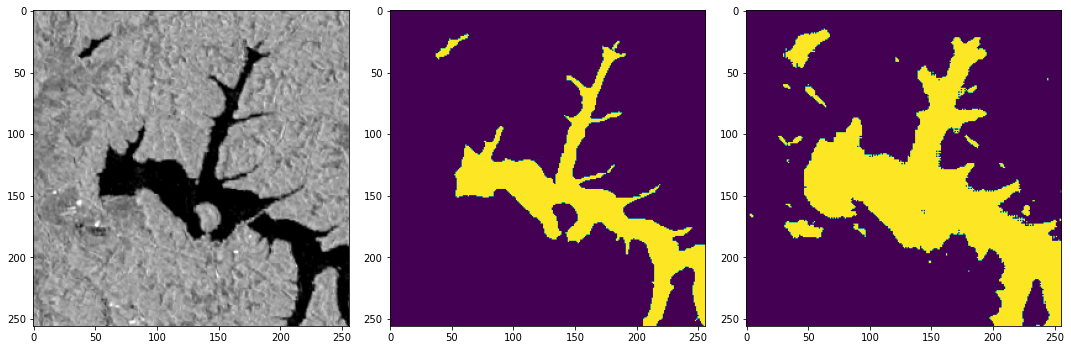

In [119]:
# for img, msk in sample_ds.take(1):
for img, msk in test_dataset.take(1):
    prediction = model.predict(img)[0]
    print(prediction_sq.shape)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(img[0].numpy())
    axes[1].imshow(msk[0].numpy())
    axes[2].imshow(np.where(prediction > 0.013, 1, 0))
    fig.tight_layout()

In [54]:
np.unique(prediction)

array([0.00029653, 0.00030947, 0.00032103, ..., 0.23231518, 0.24067631,
       0.27911276], dtype=float32)

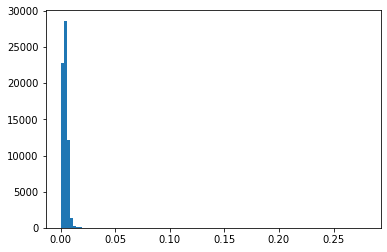

In [58]:
plt.hist(prediction.ravel(), bins=100);

In [65]:
prediction.mean(), prediction.min(), prediction.max(), np.median(prediction), np.quantile(prediction, 0.99)

(0.004337297, 0.0002965331, 0.27911276, 0.004193887, 0.010996867716312416)

In [66]:
pred_new = np.where(prediction > 0.1, 1, 0)

In [69]:
np.unique(pred_new)

array([0, 1])

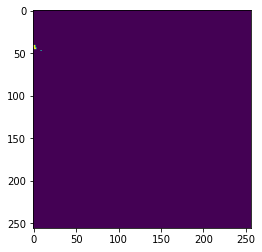

In [71]:
plt.imshow(pred_new)